Using MCMC to Fit the Shifted-Beta-Geometric Customer Lifetime Value Model
=============

Introduction
----------

Idea of the analysis was taken from the blog http://danielweitzenfeld.github.io/passtheroc/blog/2015/01/19/s-b-g/

The LTV Model allows to model 'churn rate' and 'buying rate' using shifted-beta-geometric (sBG) approach.

In [1]:
import sys

sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline

ion()
import scipy
import pymc as pm
import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Example data: shows the number of the customers after some periods of time

In [3]:
example_data = [1000, 869, 743, 653, 593, 551, 517, 491]

Then we find out how many customers left, and aggregate all data in one dataframe

In [14]:
previous_data = np.roll(example_data, -1)
lost_data = example_data -previous_data
lost_data = np.r_[[None],lost_data[:-1]]
data = (np.array(example_data),lost_data)

Here we introduce our model

In [16]:
import pymc as pm

alpha = pm.Uniform('alpha', 0.00001, 1000, value=1)  # parameters of the probability model 
beta = pm.Uniform('beta', 0.00001, 1000, value=1) # 



num_periods = len(example_data)

# determines the probability that randomly chosen customer leaves the company after some period
@pm.deterministic
def P_T_is_t(alpha=alpha, beta=beta, num_periods=num_periods):
    p = [None, alpha / (alpha + beta)]
    for t in range(2, num_periods):
        pt = (beta + t - 2) / (alpha + beta + t - 1) * p[t-1]
        p.append(pt)
    return p


# this is probability of a  randomly chosen individual survives to period t given alpha and beta
@pm.deterministic
def survival_function(P_T_is_t=P_T_is_t, num_periods=num_periods):
    s = [None, 1 - P_T_is_t[1]]
    for t in range(2, num_periods):
        s.append(s[t-1] - P_T_is_t[t]) # iteration: survival[k] = survival[k-1] - proba_to_leave[k-1]  
    return s



# likelihood function: P_T_is_t[:]*survival_function[-1]
# here P_T_is_t[:] is a product of type: (p_1)^N_1 x (p_2)^N_2 x... where (p_i,N_i) are a probability and number of customers
# to leave (die) the company
#
# survival_function[-1] --> (s_-1)^N(active)_-1 
# s_-1 -- survived function (or survived proba) and N(active)_-1 -- active customers to the
# end of the last  period 
#
# As a summary: this is a Bernoulli model
@pm.observed
def retention_rates(P_T_is_t=P_T_is_t, survival_function=survival_function, value=data):
    def logp(value, P_T_is_t, survival_function):
        
        active, lost = value
        
        # Those who've churned along the way...
# --> Log(L_died) = Log(Proba_to_leave_i), where i is an index over all 'lost' customers
        died = np.log(P_T_is_t[1:]) * lost[1:] 
        
        # and those still active in last period
        still_active = np.log(survival_function[-1]) * active[-1]              
        return sum(died) + still_active
    
# build a model    
mcmc = pm.MCMC([alpha, beta, P_T_is_t, survival_function, retention_rates])
retention_rates.logp

-2115.545506645605

In [17]:
mcmc.sample(20000, 5000, 20)

 [-----------------100%-----------------] 20000 of 20000 complete in 4.0 sec

Plotting alpha
Plotting beta


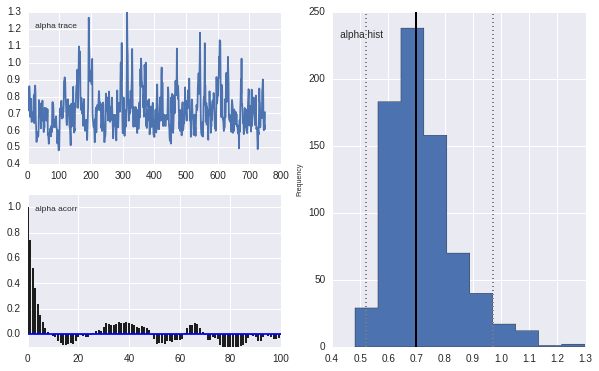

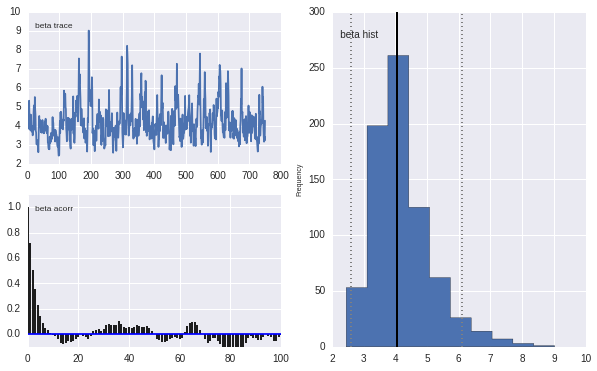

In [19]:


sns.set(style="darkgrid")
pm.Matplot.plot(alpha)
pm.Matplot.plot(beta)





In [20]:
df_trace = pd.DataFrame({'alpha': alpha.trace(), 'beta': beta.trace()})
df_trace.median()

alpha    0.698030
beta     4.039368
dtype: float64

In [25]:
print alpha.stats()['mean']
print beta.stats()['mean']

0.720392924429
4.21346524566


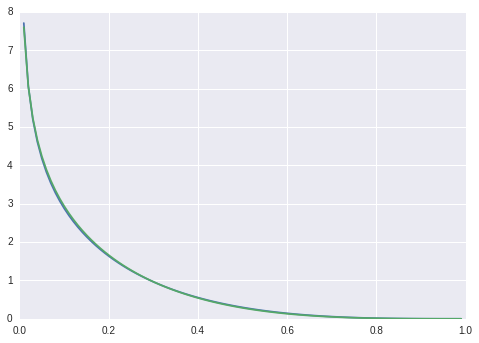

In [29]:
x = np.linspace(0, 1, 100)[1:99]
plt.plot(x, scipy.stats.beta.pdf(x, df_trace['alpha'].median(), df_trace['beta'].median()), '-') 
plt.plot(x, scipy.stats.beta.pdf(x, df_trace['alpha'].mean(), df_trace['beta'].mean()), '-') 

Discounted Expected Residual Lifetime
------------------


>The motivation for the DERL is that once you've fit an sBG model to a customer base, an obvious follow up question is, "how much money can I expect to take in from this customer base in the future?" The DERL for a customer who pays $x per period and who is at the end of their n period is the number such that DERL∗x is the expected present value of future payments from that customer. The DERL is a function of α, β, a discount rate d, and the current period n of the subscriber.

In [30]:
from scipy.special import hyp2f1

def derl(alpha, beta, d, n):
    """
    Discounted Expected Residual Lifetime, as derived in Fader and Hardie (2010).  See equation (6).

    :param alpha: sBG alpha param
    :param beta: sBG beta param
    :param d: discount rate
    :param n: customer's contract period (customer has made n-1 renewals)
    :return: float
    """
    return (beta + n - 1) / (alpha + beta + n - 1) * hyp2f1(1, beta + n, alpha + beta + n, 1 / (1 + d))

>For each draw of the posterior distribution, we'll calculate the DERL for a customer just before their first renewal decision. For the sake of example, imagine we get $10 per period from each customer, and I'll use a discount rate of 10%.

In [42]:
df_trace['derl'] = df_trace.apply(lambda x: 1 + derl(x['alpha'], x['beta'], .1, 1), axis=1)
df_trace['lifetime_value'] = 10 * df_trace.derl



# plot 95% CL HDI
median_clv = df_trace.lifetime_value.median()
cred_interval = df_trace.lifetime_value.quantile(.025), df_trace.lifetime_value.quantile(.975)
ax = df_trace['lifetime_value'].hist()
ax.set_title('Customer Lifetime Value (Discount Rate: .1)')
ax.set_xlabel('Discounted Expected Customer Lifetime')
ax.plot([median_clv, median_clv], ax.get_ylim())
plt.annotate('Median: %.1f' % median_clv, xy=(median_clv + .02, ax.get_ylim()[1]-10))
ax.plot([cred_interval[0], cred_interval[0]], ax.get_ylim(), c=sns.color_palette()[2], lw=1)
_ = ax.plot([cred_interval[1], cred_interval[1]], ax.get_ylim(), c=sns.color_palette()[2], lw=1)

So we earn about 64\$ per a customer to the end of first period if our price is 10\$

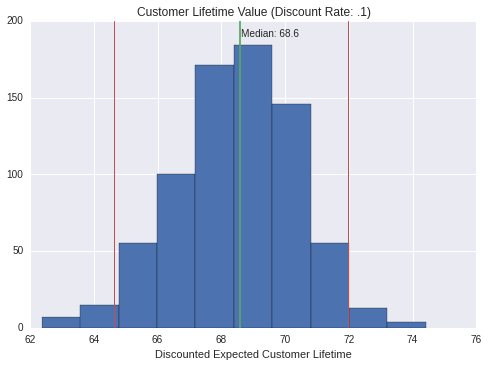

In [37]:
period=2
discount=0.1
df_trace['derl'] = df_trace.apply(lambda x: 1 + derl(x['alpha'], x['beta'], discount, period), axis=1)
df_trace['lifetime_value'] = 10 * df_trace.derl



# plot 95% CL HDI
median_clv = df_trace.lifetime_value.median()
cred_interval = df_trace.lifetime_value.quantile(.025), df_trace.lifetime_value.quantile(.975)
ax = df_trace['lifetime_value'].hist()
ax.set_title('Customer Lifetime Value (Discount Rate: .1)')
ax.set_xlabel('Discounted Expected Customer Lifetime')
ax.plot([median_clv, median_clv], ax.get_ylim())
plt.annotate('Median: %.1f' % median_clv, xy=(median_clv + .02, ax.get_ylim()[1]-10))
ax.plot([cred_interval[0], cred_interval[0]], ax.get_ylim(), c=sns.color_palette()[2], lw=1)
_ = ax.plot([cred_interval[1], cred_interval[1]], ax.get_ylim(), c=sns.color_palette()[2], lw=1)

So we earn about 69\$ per survived customer to the end of second period if our price is 10\$

>As we get more data, our credible interval should shrink. Let's confirm by imagining we had 10x the data:

In [38]:
example_data = [10 * x for x in example_data]

previous_data = np.roll(example_data, -1)
lost_data = example_data -previous_data
lost_data = np.r_[[None],lost_data[:-1]]
data = (np.array(example_data),lost_data)



In [39]:
@pm.observed
def retention_rates(P_T_is_t=P_T_is_t, survival_function=survival_function, value=data):
    def logp(value, P_T_is_t, survival_function):
        
        active, lost = value
        
        # Those who've churned along the way...
# --> Log(L_died) = Log(Proba_to_leave_i), where i is an index over all 'lost' customers
        died = np.log(P_T_is_t[1:]) * lost[1:] 
        
        # and those still active in last period
        still_active = np.log(survival_function[-1]) * active[-1]              
        return sum(died) + still_active
    
# build a model    
mcmc = pm.MCMC([alpha, beta, P_T_is_t, survival_function, retention_rates])
mcmc.sample(20000, 5000, 20)

 [-----------------100%-----------------] 20000 of 20000 complete in 5.1 sec

In [40]:
df_trace_10x = pd.DataFrame({'alpha': alpha.trace(), 'beta': beta.trace()})
df_trace_10x['derl'] = df_trace_10x.apply(lambda x: 1 + derl(x['alpha'], x['beta'], .1, 1), axis=1)
df_trace_10x['lifetime_value'] = 10 * df_trace_10x.derl

In [43]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

plots = [(ax1, df_trace, 'Original N'), (ax2, df_trace_10x, '10x N')]
for ax, df, title in plots:
    median_clv = df.lifetime_value.median()
    cred_interval = df.lifetime_value.quantile(.025), df.lifetime_value.quantile(.975)
    df['lifetime_value'].hist(ax=ax, lw=0)
    ax.plot([median_clv, median_clv], ax.get_ylim())
    ax.plot([cred_interval[0], cred_interval[0]], ax.get_ylim(), c=sns.color_palette()[2], lw=1)
    _ = ax.plot([cred_interval[1], cred_interval[1]], ax.get_ylim(), c=sns.color_palette()[2], lw=1)
    ax.text(.99, .9, title, verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=14)

ax2.set_xlabel('Discounted Expected Customer Lifetime')
_ = f.suptitle('Customer Lifetime Value (Discount Rate: .1), With Original and 10x Sample Size', fontsize=14)